In [34]:
!pip install keras-tuner

In [35]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")
df = df[(df["item"]==1) & (df['store']==1)] # Store 1 and item 1 only
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

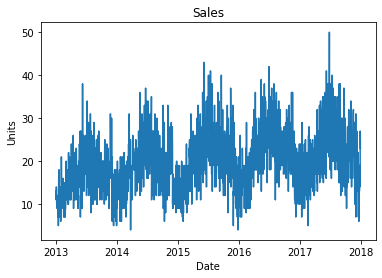

In [38]:
plt.plot(df['date'],df['sales'])
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Units')
plt.show()

In [39]:
raw_seq = df['sales']

In [40]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [41]:
def mlp_model(hp):
  model = tf.keras.Sequential() 
  model.add(Input(shape=5))


  for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    hp_activation=hp.Choice('activation' + str(i), ['relu', 'tanh'])
    model.add(Dense(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation=hp_activation))
    model.add(Dropout(hp.Float('dropout' + str(i), 0, 0.5, step=0.1, default=0)))

  model.add(Dense(1, activation='linear'))

  model.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

  return model

In [42]:
tuner = kt.tuners.Hyperband(
    mlp_model,
    objective='val_mean_squared_error',
    max_epochs=30,
    hyperband_iterations=5,
    directory='dnn_exp',
    project_name='demand forecasting')

In [43]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
activation0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout0 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout1 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [44]:
X, y = split_sequence(raw_seq, n_steps=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = mlp_model(n_steps)

In [45]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [46]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[stop_early])

Trial 450 Complete [00h 00m 05s]
val_mean_squared_error: 46.89179229736328

Best val_mean_squared_error So Far: 34.29505920410156
Total elapsed time: 00h 31m 21s
INFO:tensorflow:Oracle triggered exit


In [47]:
tuner.results_summary()

Results summary
Results in dnn_exp/demand forecasting
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 4
activation0: relu
units0: 512
dropout0: 0.4
activation1: relu
units1: 320
dropout1: 0.1
activation2: tanh
units2: 224
dropout2: 0.2
activation3: relu
units3: 416
dropout3: 0.4
activation4: relu
units4: 288
dropout4: 0.0
activation5: relu
units5: 288
dropout5: 0.4
activation6: relu
units6: 416
dropout6: 0.0
activation7: tanh
units7: 64
dropout7: 0.30000000000000004
activation8: tanh
units8: 288
dropout8: 0.1
activation9: relu
units9: 96
dropout9: 0.5
activation10: tanh
units10: 96
dropout10: 0.1
activation11: tanh
units11: 128
dropout11: 0.30000000000000004
activation12: tanh
units12: 512
dropout12: 0.30000000000000004
activation13: relu
units13: 416
dropout13: 0.1
activation14: tanh
units14: 256
dropout14: 0.2
activation15: relu
units15: 320
dropout15: 0.30000000000000004
activation16: tanh
units16: 352
dropo

In [48]:
best_model = tuner.get_best_models()[0]
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               3072      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 320)               164160    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 224)               71904     
                                                                 
 dropout_2 (Dropout)         (None, 224)               0         
                                                                 
 dense_3 (Dense)             (None, 416)               9

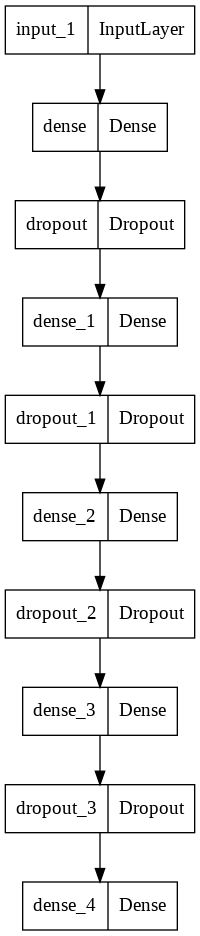

In [49]:
plot_model(best_model)